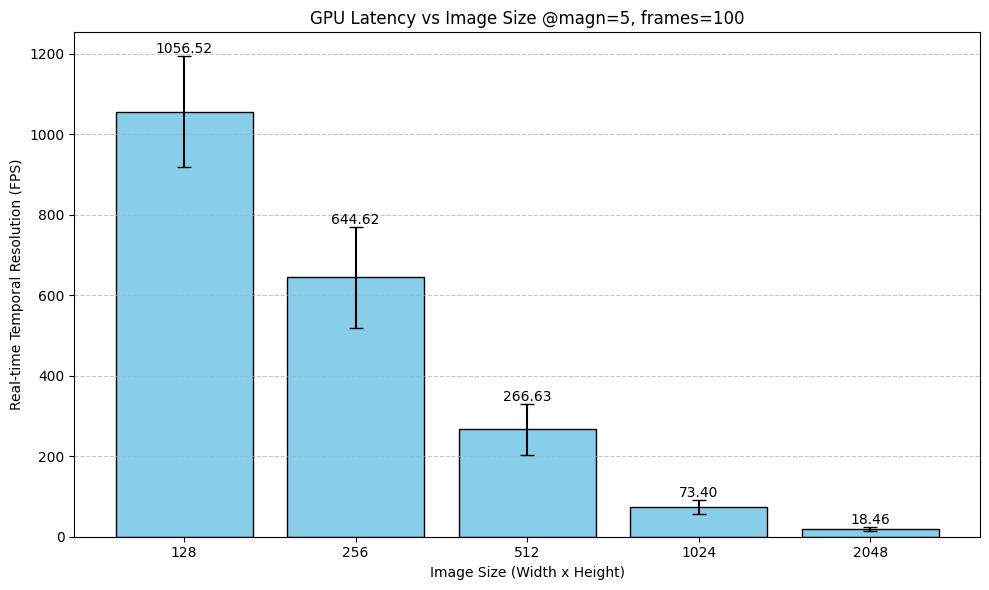

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the latency results
data = pd.read_csv("latency_results.csv")

# Extract just the width (assuming square images)
sizes = data["Width"].astype(str)  # use as x-tick labels
avg_times = data["AverageTime_ms"]
std_devs = np.sqrt(data["Variance_ms2"])

# Convert latency to frames per second (FPS)
fps = 1000 / avg_times  # FPS = 1000 / Latency (ms)
fps_error = (1000 / avg_times**2) * std_devs  # Error bars for FPS

# Bar plot
plt.figure(figsize=(10, 6))
x_pos = np.arange(len(sizes))

plt.bar(x_pos, fps, yerr=fps_error, capsize=5, color='skyblue', edgecolor='black')

# Annotate each bar with its FPS value
for i, value in enumerate(fps):
    plt.text(x_pos[i], value + fps_error[i] + 0.5, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

# Set labels and ticks
plt.xticks(x_pos, sizes)
plt.xlabel("Image Size (Width x Height)")
plt.ylabel("Real-time Temporal Resolution (FPS)")
plt.title("GPU Latency vs Image Size @magn=5, frames=100")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save and show
plt.tight_layout()
plt.savefig("latency_bar_plot_with_fps.png", dpi=300)
plt.show()


In [1]:
!pip install cupy-cuda12x
!pip install nanopyx[jupyter]

   ---------------------------------------- 0.0/82.2 MB ? eta -:--:--
   ----- ---------------------------------- 11.3/82.2 MB 58.6 MB/s eta 0:00:02
   ---------- ----------------------------- 21.0/82.2 MB 55.2 MB/s eta 0:00:02
   -------------- ------------------------- 30.4/82.2 MB 52.2 MB/s eta 0:00:01
   ------------------------ --------------- 50.3/82.2 MB 59.3 MB/s eta 0:00:01
   --------------------------------- ------ 68.2/82.2 MB 64.8 MB/s eta 0:00:01
   ---------------------------------------  81.5/82.2 MB 64.2 MB/s eta 0:00:01
   ---------------------------------------- 82.2/82.2 MB 58.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached celluloid-0.2.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached argon2_cffi-23.1.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached argon2_cffi_bindings-21.2.0-cp36-abi3-win_amd64.whl.metadata (6.7 kB)
  Using cached defusedxml-0.7.1-py2.py3-none-any.whl.metadata (32 kB)
  Using cached fqdn-1.5.1-py3-none-any.whl.metadata (1.4 kB)
  Using cached arrow-1.3.0-py3-none-any.whl.metadata (7.5 kB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 38.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ---------------------------------------- 12.3/12.3 MB 77.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   --------------------- ------------------ 21.0/39.5 MB 102.0 MB/s eta 0:00:01
   ---------------------------------------  39.3/39.5 MB 99.9 MB/s eta 0:00:01
   ---------------------------------------- 39.5/39.5 MB 81.0 M


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pyopencl as cl
platforms = cl.get_platforms()
print("Available OpenCL platforms:")
for platform in platforms:
    print(platform.name)

Available OpenCL platforms:
NVIDIA CUDA


In [ ]:
import csv
import numpy as np
import time
from nanopyx.methods import eSRRF
from nanopyx.core.transform.sr_temporal_correlations import (
    calculate_eSRRF_temporal_correlations,
)

def benchmark_esrrf(frame_sizes, iterations=100, num_frames=100, magn=5):
    results = []

    for size in frame_sizes:
        print(f"\nBenchmarking frame size: {size}x{size}, {num_frames} frames")
        latencies = []
        block = np.random.rand(num_frames-1, size*magn, size*magn).astype(np.float32)

        for _ in range(iterations):
            # Generate a synthetic image stack (block) [time, height, width]
            frame = np.random.rand(num_frames, size, size).astype(np.float32)

            start_time = time.time()
            result = eSRRF(
                frame,
                magnification=5,
                radius=2,
                sensitivity=1.0,
                doIntensityWeighting=True,
                macro_pixel_correction=False,
            )

            block = np.concatenate([block, result])
            _ = calculate_eSRRF_temporal_correlations(block, "TAC2")
            end_time = time.time()
            block = block[-100:]
            latencies.append(end_time - start_time)

        avg_latency_ms = np.mean(latencies) * 1000
        var_latency_ms2 = np.var(latencies) * 1000**2

        results.append((size, size, avg_latency_ms, var_latency_ms2))

        print(f"→ Avg: {avg_latency_ms:.4f} ms | Variance: {var_latency_ms2:.4f} ms²")

    return results

def save_results_to_csv(results, filename="esrrf_benchmark.csv"):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Width", "Height", "AverageTime_ms", "Variance_ms2"])
        writer.writerows(results)
    print(f"\nResults saved to: {filename}")

if __name__ == "__main__":
    frame_sizes = [128, 256, 512, 1024, 2048]
    benchmark_results = benchmark_esrrf(frame_sizes)
    save_results_to_csv(benchmark_results)


UnboundLocalError: cannot access local variable 'size' where it is not associated with a value

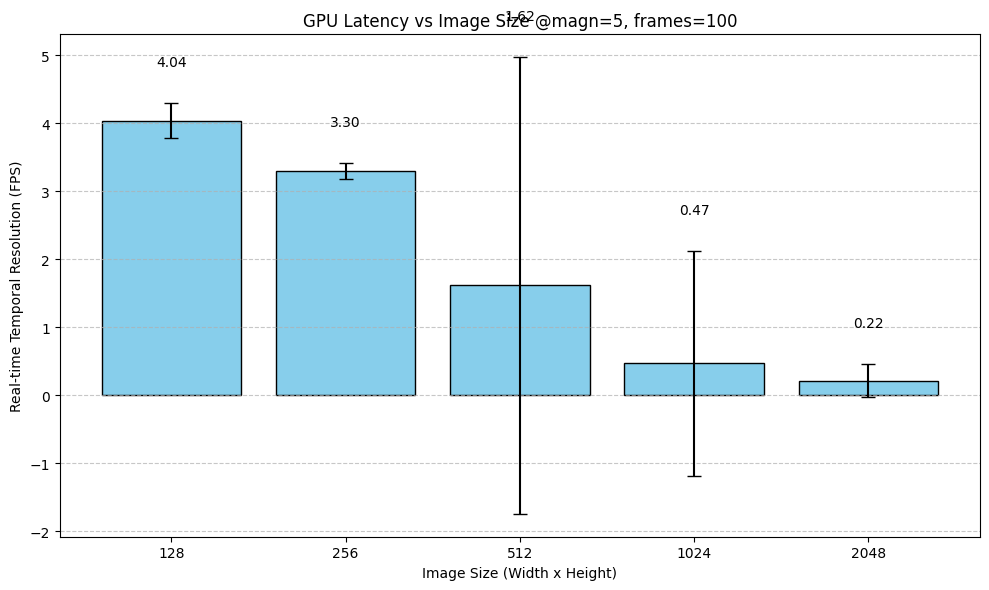

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the latency results
data = pd.read_csv("esrrf_benchmark.csv")

# Extract just the width (assuming square images)
sizes = data["Width"].astype(str)  # use as x-tick labels
avg_times = data["AverageTime_ms"]
std_devs = np.sqrt(data["Variance_ms2"])

# Convert latency to frames per second (FPS)
fps = 1000 / avg_times  # FPS = 1000 / Latency (ms)
fps_error = (1000 / avg_times**2) * std_devs  # Error bars for FPS

# Bar plot
plt.figure(figsize=(10, 6))
x_pos = np.arange(len(sizes))

plt.bar(x_pos, fps, yerr=fps_error, capsize=5, color='skyblue', edgecolor='black')

# Annotate each bar with its FPS value
for i, value in enumerate(fps):
    plt.text(x_pos[i], value + fps_error[i] + 0.5, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

# Set labels and ticks
plt.xticks(x_pos, sizes)
plt.xlabel("Image Size (Width x Height)")
plt.ylabel("Real-time Temporal Resolution (FPS)")
plt.title("GPU Latency vs Image Size @magn=5, frames=100")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save and show
plt.tight_layout()
plt.savefig("latency_bar_plot_with_fps.png", dpi=300)
plt.show()


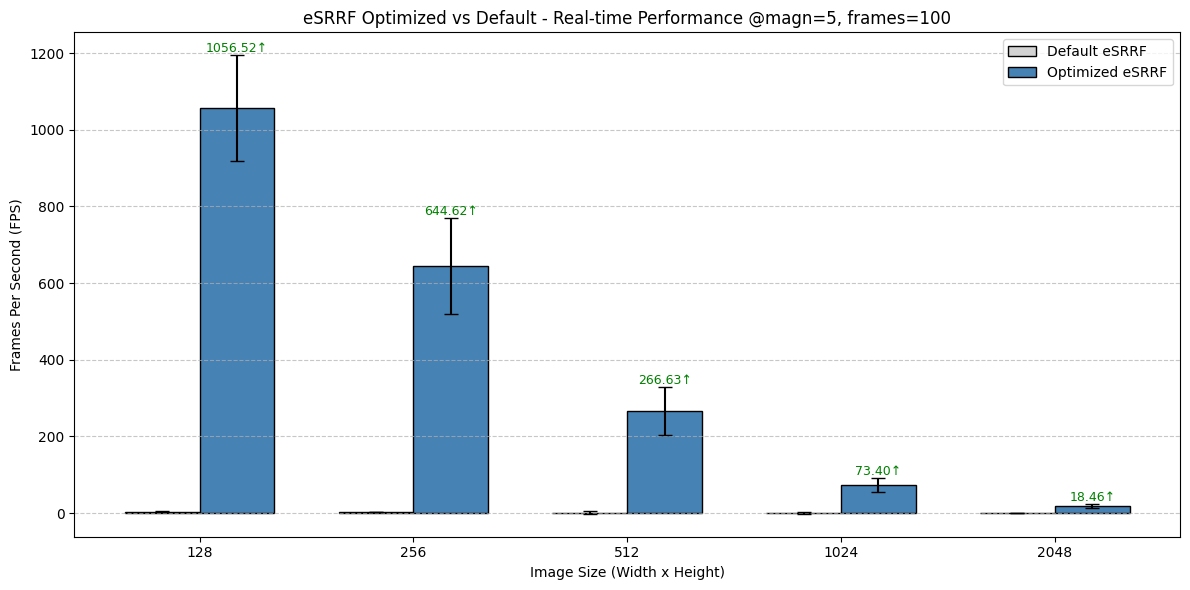

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load both CSVs
default_data = pd.read_csv("esrrf_benchmark.csv")
optimized_data = pd.read_csv("latency_results.csv")

# Assume both have the same image sizes
sizes = default_data["Width"].astype(str)

# Calculate FPS and error bars
def calc_fps_and_error(df):
    avg_times = df["AverageTime_ms"]
    std_devs = np.sqrt(df["Variance_ms2"])
    fps = 1000 / avg_times
    fps_error = (1000 / avg_times**2) * std_devs
    return fps, fps_error

default_fps, default_fps_err = calc_fps_and_error(default_data)
optimized_fps, optimized_fps_err = calc_fps_and_error(optimized_data)

# Plot
x = np.arange(len(sizes))
width = 0.35

plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width/2, default_fps, width, yerr=default_fps_err, capsize=5, label='Default eSRRF', color='lightgray', edgecolor='black')
bars2 = plt.bar(x + width/2, optimized_fps, width, yerr=optimized_fps_err, capsize=5, label='Optimized eSRRF', color='steelblue', edgecolor='black')

# Annotate performance improvement
for i in range(len(x)):
    if optimized_fps[i] > default_fps[i]:
        plt.text(x[i] + width/2, optimized_fps[i] + optimized_fps_err[i] + 0.5,
                 f'{optimized_fps[i]:.2f}↑', ha='center', va='bottom', fontsize=9, color='green')
    else:
        plt.text(x[i] + width/2, optimized_fps[i] + optimized_fps_err[i] + 0.5,
                 f'{optimized_fps[i]:.2f}', ha='center', va='bottom', fontsize=9)

# Axis settings
plt.xticks(x, sizes)
plt.xlabel("Image Size (Width x Height)")
plt.ylabel("Frames Per Second (FPS)")
plt.title("eSRRF Optimized vs Default - Real-time Performance @magn=5, frames=100")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save and display
plt.tight_layout()
plt.savefig("esrrf_comparison_plot.png", dpi=300)
plt.show()
